In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import sys
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
sys.path.append(project_root)

from models import AttentionVNet, VNet
from lit_models import LitBaseVNet
from dataloader import ProstateDataModule, download_and_extract_msd_prostate


In [2]:
DATA_ROOT = "../data"
download_and_extract_msd_prostate(DATA_ROOT)

dm = ProstateDataModule(
    root_dir=DATA_ROOT, 
    batch_size=2,
    roi_size=(128, 128, 64),
    num_workers=10
)

model_inner = AttentionVNet(in_ch=2, out_ch=3, base_channels=64) 
model = LitBaseVNet(model_obj=model_inner, in_ch=2, out_ch=3, lr=1e-3)

In [4]:
checkpoint_callback = ModelCheckpoint(
    monitor="val_dice",
    dirpath="../checkpoints/",
    filename="best-attention-vnet-{epoch:02d}-{val_dice:.3f}",
    save_top_k=1,
    mode="max",
)

early_stop_callback = EarlyStopping(
    monitor="val_dice",
    patience=10,
    mode="max",
    verbose=True
)

logger = TensorBoardLogger("../tb_logs", name="AttentionVNet_Prostate")

trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    callbacks=[checkpoint_callback, early_stop_callback],
    logger=logger,
    log_every_n_steps=10
)

trainer.fit(model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                   | Params | Mode 
----------------------------------------------------

Epoch 0: 100%|██████████| 13/13 [06:09<00:00,  0.04it/s, v_num=0, val_loss=1.090, val_dice=0.356, val_miou=0.351, train_loss=1.100]

Metric val_dice improved. New best score: 0.356


Epoch 1: 100%|██████████| 13/13 [05:35<00:00,  0.04it/s, v_num=0, val_loss=1.140, val_dice=0.381, val_miou=0.309, train_loss=0.670]

Metric val_dice improved by 0.025 >= min_delta = 0.0. New best score: 0.381


Epoch 2: 100%|██████████| 13/13 [05:36<00:00,  0.04it/s, v_num=0, val_loss=1.070, val_dice=0.415, val_miou=0.341, train_loss=0.612]

Metric val_dice improved by 0.035 >= min_delta = 0.0. New best score: 0.415


Epoch 3: 100%|██████████| 13/13 [05:35<00:00,  0.04it/s, v_num=0, val_loss=0.669, val_dice=0.437, val_miou=0.377, train_loss=0.551]

Metric val_dice improved by 0.021 >= min_delta = 0.0. New best score: 0.437


Epoch 4: 100%|██████████| 13/13 [05:35<00:00,  0.04it/s, v_num=0, val_loss=0.558, val_dice=0.558, val_miou=0.472, train_loss=0.494]

Metric val_dice improved by 0.121 >= min_delta = 0.0. New best score: 0.558


Epoch 12: 100%|██████████| 13/13 [05:34<00:00,  0.04it/s, v_num=0, val_loss=0.609, val_dice=0.580, val_miou=0.462, train_loss=0.440]

Metric val_dice improved by 0.022 >= min_delta = 0.0. New best score: 0.580


Epoch 20: 100%|██████████| 13/13 [05:35<00:00,  0.04it/s, v_num=0, val_loss=0.538, val_dice=0.594, val_miou=0.475, train_loss=0.396]

Metric val_dice improved by 0.014 >= min_delta = 0.0. New best score: 0.594


Epoch 25: 100%|██████████| 13/13 [05:34<00:00,  0.04it/s, v_num=0, val_loss=0.513, val_dice=0.610, val_miou=0.500, train_loss=0.362]

Metric val_dice improved by 0.016 >= min_delta = 0.0. New best score: 0.610


Epoch 31: 100%|██████████| 13/13 [05:34<00:00,  0.04it/s, v_num=0, val_loss=0.511, val_dice=0.616, val_miou=0.503, train_loss=0.337]

Metric val_dice improved by 0.006 >= min_delta = 0.0. New best score: 0.616


Epoch 41: 100%|██████████| 13/13 [05:34<00:00,  0.04it/s, v_num=0, val_loss=0.546, val_dice=0.591, val_miou=0.477, train_loss=0.314]

Monitored metric val_dice did not improve in the last 10 records. Best score: 0.616. Signaling Trainer to stop.


Epoch 41: 100%|██████████| 13/13 [05:34<00:00,  0.04it/s, v_num=0, val_loss=0.546, val_dice=0.591, val_miou=0.477, train_loss=0.314]


monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.


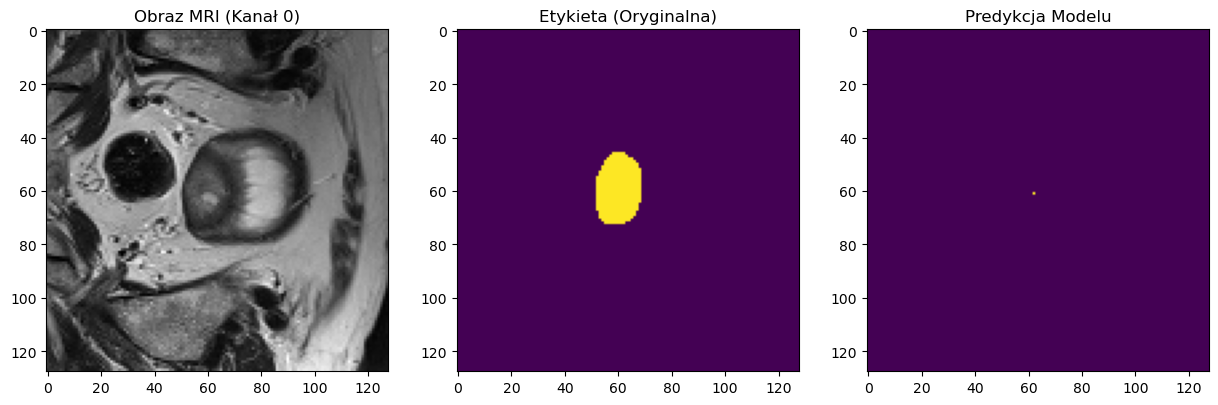

In [3]:
checkpoint_path = "../checkpoints/best-attention-vnet-epoch=31-val_dice=0.616.ckpt"
model = LitBaseVNet.load_from_checkpoint(
    checkpoint_path, 
    model_obj=AttentionVNet(in_ch=2, out_ch=3, base_channels=64)
)
model.eval()
model.cuda()

dm.setup(stage="fit")
batch = next(iter(dm.val_dataloader()))

x, y = model._prepare_batch(batch)
x = x.cuda()

with torch.no_grad():
    logits = model(x)
    preds = torch.argmax(logits, dim=1)

slice_idx = 32 # Przekrój w połowie głębokości (roi_size to 64)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Obraz MRI (Kanał 0)")
plt.imshow(x[0, 0, :, :, slice_idx].cpu(), cmap="gray")

plt.subplot(1, 3, 2)
plt.title("Etykieta (Oryginalna)")
plt.imshow(y[0, 0, :, :, slice_idx].cpu())

plt.subplot(1, 3, 3)
plt.title("Predykcja Modelu")
plt.imshow(preds[0, :, :, slice_idx].cpu())

plt.show()

# To run tensorboard graphs, enter in the console:
tensorboard --logdir tb_logs  

<br>
<br>


---
# The charts display two lines: a lighter line for actual values and a bold line for the smoothed trend.

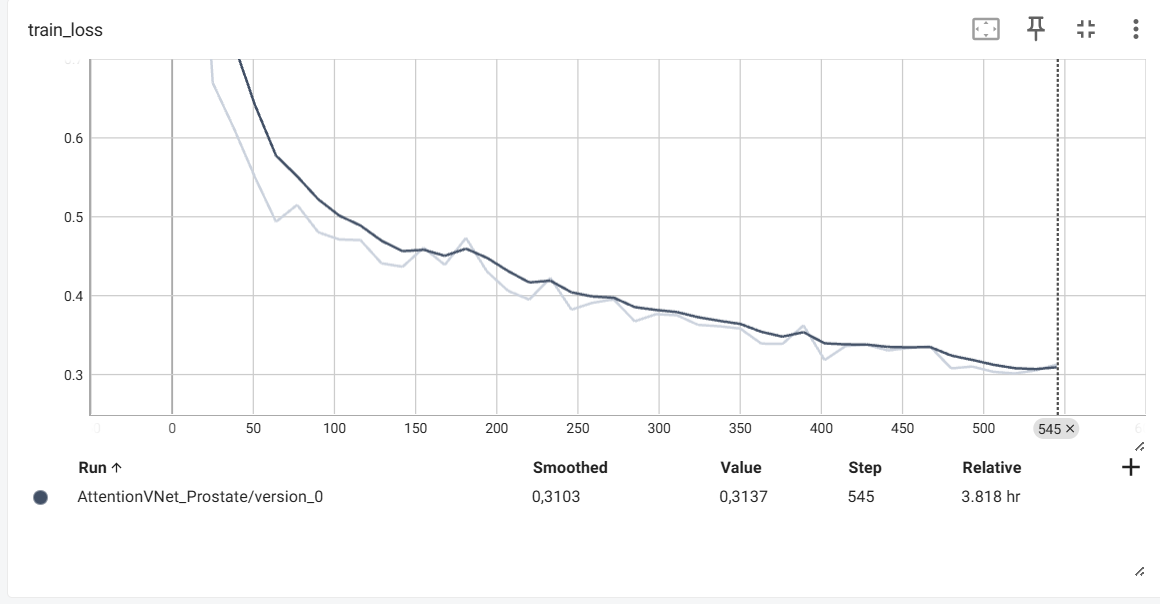

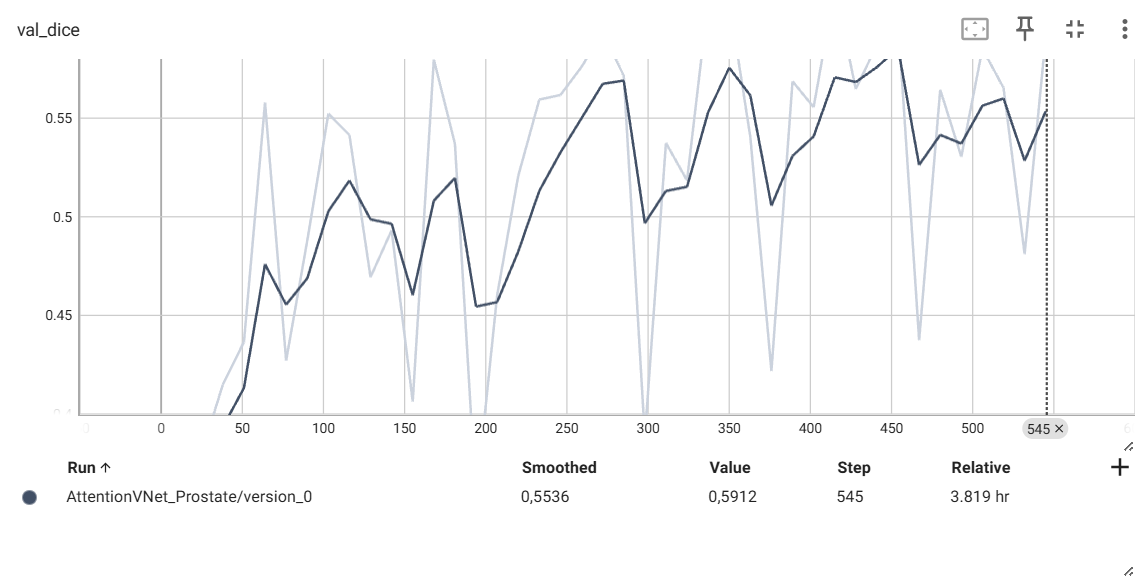

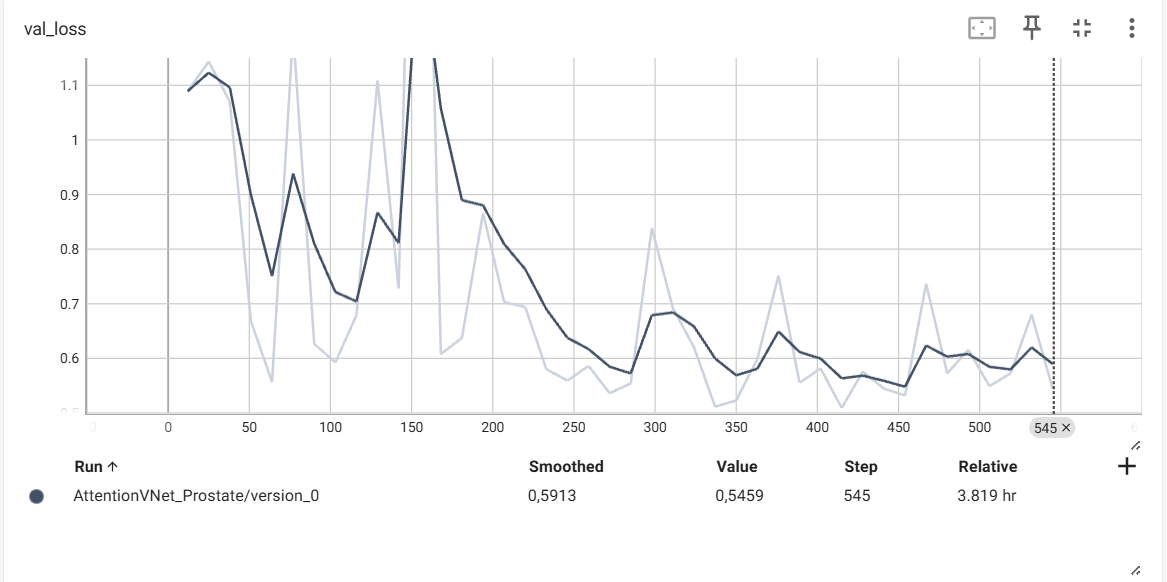

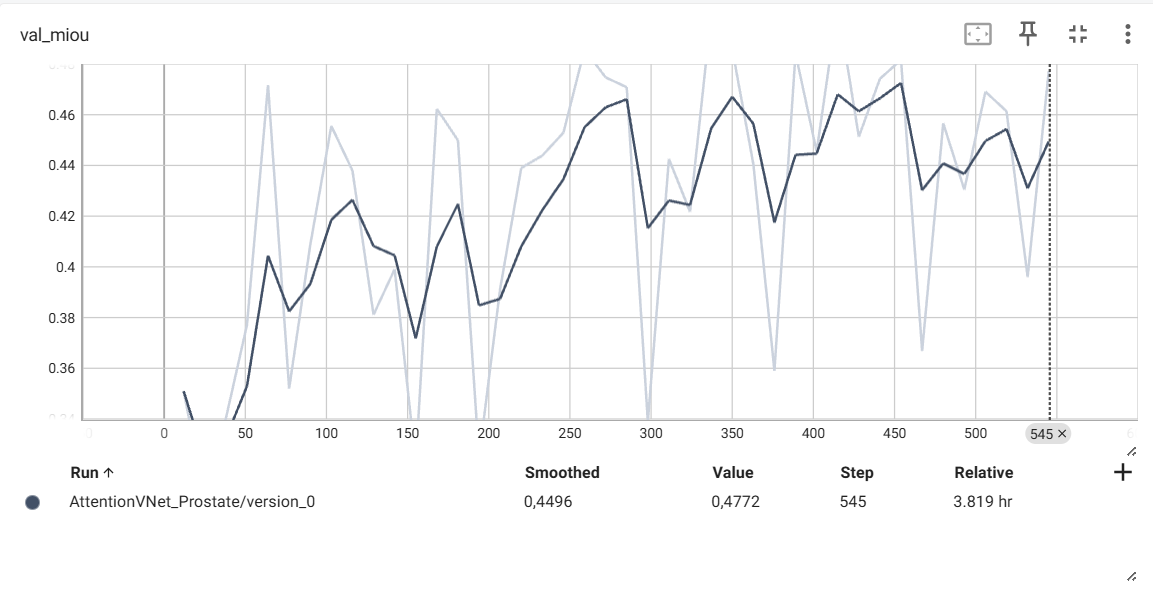

In [4]:
plain_vnet = VNet(in_ch=2, out_ch=3, base_channels=64)
model_vnet = LitBaseVNet(model_obj=plain_vnet, in_ch=2, out_ch=3, lr=1e-3)

vnet_logger = TensorBoardLogger(
    save_dir="../tb_logs", 
    name="vnet"
)

vnet_callbacks = [
    ModelCheckpoint(
        dirpath="../checkpoints_vnet/",
        filename="best-vnet-{epoch:02d}-{val_dice:.3f}",
        monitor="val_dice",
        mode="max",
        save_top_k=1
    ),
    EarlyStopping(monitor="val_dice", patience=10, mode="max",verbose=True),
    LearningRateMonitor(logging_interval="epoch")
]

trainer_vnet = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    logger=vnet_logger,
    callbacks=vnet_callbacks,
    log_every_n_steps=10
)

trainer_vnet.fit(model_vnet, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                   | Params | Mode 
---------------------------------------------------------------
0 | model       | VNet                   | 47.0 M | train
1 | loss_fn     | DiceCELoss             | 0      | train
2 | miou_metric | MulticlassJaccardIndex | 0      | train
---------------------------------------------------------------
47.0 M    Trainable params
0         Non-trainable params
47.0 M    Total params
187.837   Total estimated model params size (MB)
109       Mo

Epoch 0: 100%|██████████| 13/13 [06:18<00:00,  0.03it/s, v_num=0, val_loss=31.10, val_dice=0.215, val_miou=0.138, train_loss=1.050]

Metric val_dice improved. New best score: 0.215


Epoch 1: 100%|██████████| 13/13 [06:19<00:00,  0.03it/s, v_num=0, val_loss=0.811, val_dice=0.398, val_miou=0.376, train_loss=0.628]

Metric val_dice improved by 0.183 >= min_delta = 0.0. New best score: 0.398


Epoch 3: 100%|██████████| 13/13 [06:11<00:00,  0.04it/s, v_num=0, val_loss=0.603, val_dice=0.524, val_miou=0.425, train_loss=0.539]

Metric val_dice improved by 0.126 >= min_delta = 0.0. New best score: 0.524


Epoch 8: 100%|██████████| 13/13 [06:11<00:00,  0.04it/s, v_num=0, val_loss=0.652, val_dice=0.553, val_miou=0.455, train_loss=0.486]

Metric val_dice improved by 0.029 >= min_delta = 0.0. New best score: 0.553


Epoch 11: 100%|██████████| 13/13 [06:11<00:00,  0.04it/s, v_num=0, val_loss=0.590, val_dice=0.558, val_miou=0.471, train_loss=0.457]

Metric val_dice improved by 0.005 >= min_delta = 0.0. New best score: 0.558


Epoch 21: 100%|██████████| 13/13 [06:11<00:00,  0.04it/s, v_num=0, val_loss=0.560, val_dice=0.569, val_miou=0.457, train_loss=0.407]

Metric val_dice improved by 0.011 >= min_delta = 0.0. New best score: 0.569


Epoch 31: 100%|██████████| 13/13 [06:10<00:00,  0.04it/s, v_num=0, val_loss=0.621, val_dice=0.559, val_miou=0.469, train_loss=0.360]

Monitored metric val_dice did not improve in the last 10 records. Best score: 0.569. Signaling Trainer to stop.


Epoch 31: 100%|██████████| 13/13 [06:10<00:00,  0.04it/s, v_num=0, val_loss=0.621, val_dice=0.559, val_miou=0.469, train_loss=0.360]


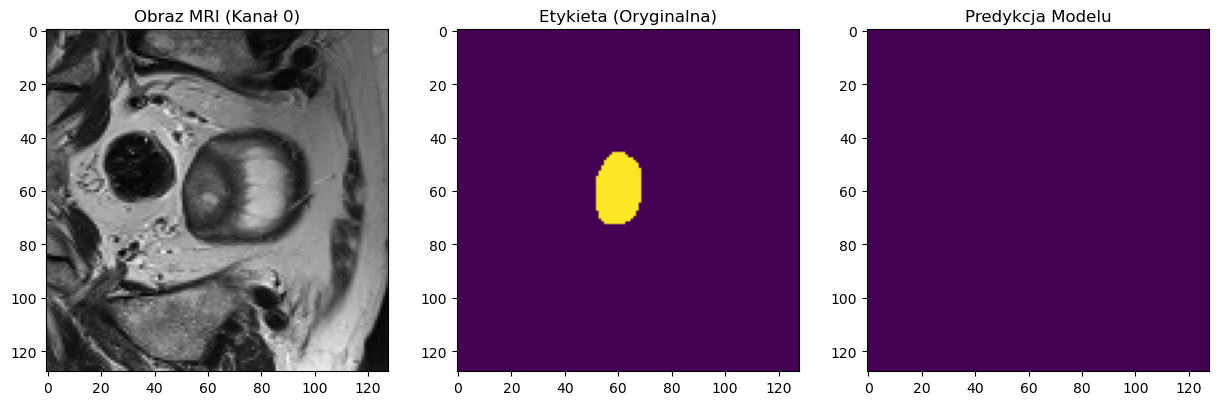

In [7]:
checkpoint_vnet_path = "../checkpoints_vnet/best-vnet-epoch=21-val_dice=0.569.ckpt"

model_vnet = LitBaseVNet.load_from_checkpoint(
    checkpoint_vnet_path, 
    model_obj=plain_vnet
)
model_vnet.eval()
model_vnet.cuda()

dm.setup(stage="fit")
batch = next(iter(dm.val_dataloader()))

x, y = model_vnet._prepare_batch(batch)
x = x.cuda()

with torch.no_grad():
    logits = model_vnet(x)
    preds = torch.argmax(logits, dim=1)

slice_idx = 32 # Przekrój w połowie głębokości (roi_size to 64)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Obraz MRI (Kanał 0)")
plt.imshow(x[0, 0, :, :, slice_idx].cpu(), cmap="gray")

plt.subplot(1, 3, 2)
plt.title("Etykieta (Oryginalna)")
plt.imshow(y[0, 0, :, :, slice_idx].cpu())

plt.subplot(1, 3, 3)
plt.title("Predykcja Modelu")
plt.imshow(preds[0, :, :, slice_idx].cpu())

plt.show()

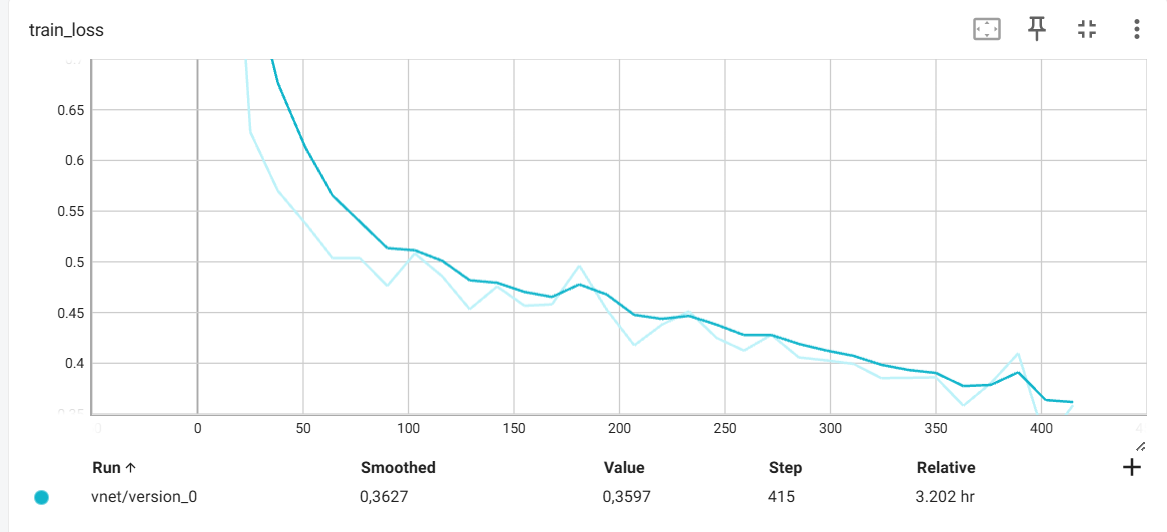
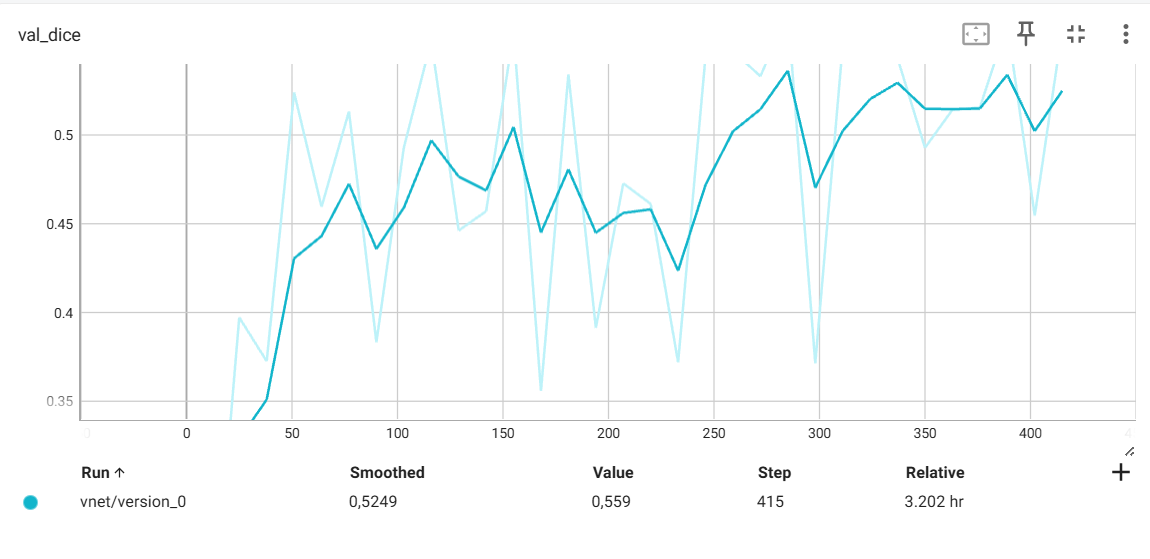
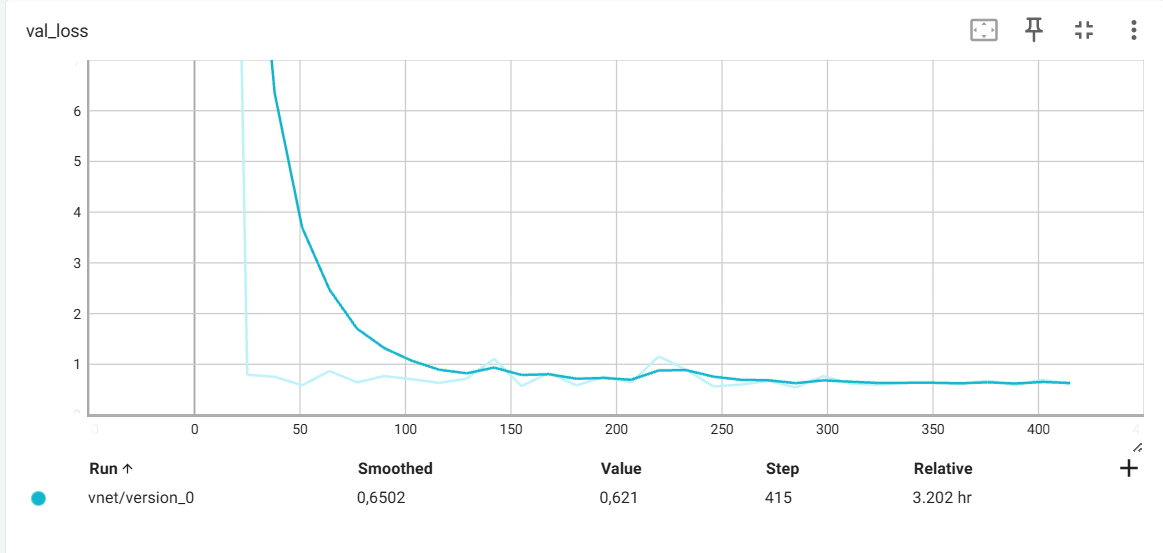
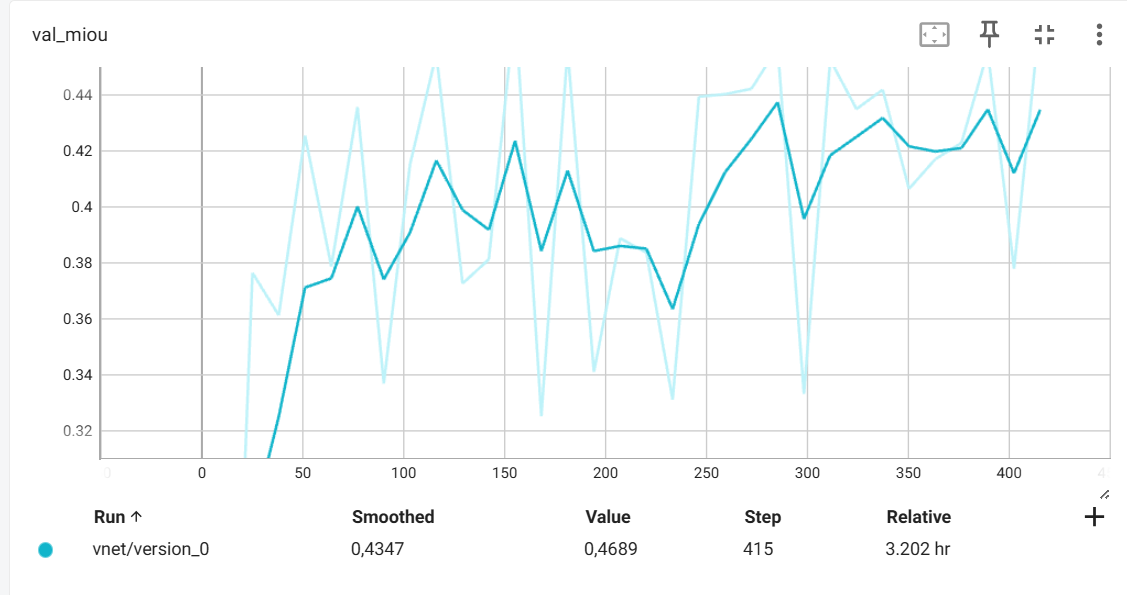